In [52]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [53]:
# Constantes físicas
G = 9.81  # Gravedad (m/s²)

### **Función `calcular_trayectoria`**

Esta función simula la trayectoria de un proyectil considerando las ecuaciones diferenciales dadas:

- Aceleración en la dirección horizontal (\(x\)):
  \[
  a_x = (-c\m) \* v_x
  \]
- Aceleración en la dirección vertical (\(y\)):
  \[
  a_y = -g - (c/m) \* v_y
  \]

La función utiliza métodos de integración numérica para calcular la posición y la velocidad del proyectil en pasos discretos de tiempo (\(dt\)).

---

### **Parámetros**

1. **`v0` (float)**:

   - Velocidad inicial del proyectil (en m/s).

2. **`angulo` (float)**:

   - Ángulo de lanzamiento del proyectil (en grados).

3. **`masa` (float)**:

   - Masa del proyectil (en kg).

4. **`c` (float)**:

   - Constante de resistencia del aire (en kg/s).

5. **`dt` (float, opcional, por defecto=0.01)**:

   - Incremento de tiempo para la simulación (en segundos).

6. **`max_t` (float, opcional, por defecto=10)**:
   - Tiempo máximo de simulación (en segundos).

---

### **Cálculos Principales**

#### **1. Conversión del ángulo a radianes**

```python
theta = np.radians(angulo)
```

Convierte el ángulo de lanzamiento, dado en grados, a radianes para usar funciones trigonométricas.

#### **2. Componentes iniciales de la velocidad**

```python
vx = v0 * np.cos(theta)
vy = v0 * np.sin(theta)
```

- \(v_x\): Componente horizontal de la velocidad inicial.
- \(v_y\): Componente vertical de la velocidad inicial.

#### **3. Inicialización de posiciones**

```python
x, y = 0, 0
```

La posición inicial del proyectil es el origen (\(x = 0\), \(y = 0\)).

#### **4. Almacenamiento de la trayectoria**

```python
xs, ys = [x], [y]
```

Inicializa listas para almacenar las posiciones horizontales (\(x\)) y verticales (\(y\)) en cada paso.

#### **5. Ciclo de integración numérica**

El bucle **while** simula la trayectoria del proyectil hasta que:

1. El proyectil toca el suelo (\(y === 0\)).
2. El tiempo de simulación alcanza el máximo permitido (\(t === max_t\)).

### **Salida**

La función devuelve dos arreglos NumPy:

1. **`xs` (array):** Posiciones horizontales del proyectil en cada instante de tiempo.
2. **`ys` (array):** Posiciones verticales del proyectil en cada instante de tiempo.


In [54]:
# Generación de datos
def calcular_trayectoria(v0, angulo, masa, c, dt=0.01, max_t=10):
    """
    Calcula la trayectoria de un proyectil considerando las ecuaciones diferenciales dadas:
    ax = -c/m * vx
    ay = -g - c/m * vy
    """
    # Convertir ángulo a radianes
    theta = np.radians(angulo)

    # Componentes iniciales de la velocidad
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    # Posiciones iniciales
    x, y = 0, 0

    # Almacenar trayectoria
    xs, ys = [x], [y]

    # Simulación por integración numérica
    t = 0
    while y >= 0 and t < max_t:
        # Aceleraciones basadas en las ecuaciones diferenciales
        ax = -c / masa * vx
        ay = -G - (c / masa) * vy

        # Actualizar velocidades
        vx += ax * dt
        vy += ay * dt

        # Actualizar posiciones
        x += vx * dt
        y += vy * dt

        # Guardar puntos de la trayectoria
        xs.append(x)
        ys.append(y)

        # Incrementar tiempo
        t += dt

    return np.array(xs), np.array(ys)


### **La Función `generar_datos`**

Esta función genera un conjunto de datos basado en las ecuaciones diferenciales del movimiento del proyectil considerando resistencia del aire y gravedad. Es ideal para crear datos de entrada y salida para modelos de machine learning.

---

### **Parámetros**

1. **`n_samples` (int, opcional, por defecto=5000):**
   - Número de muestras (proyectiles) que se generarán.

---

### **Cálculos Principales**

#### **1. Generación de Parámetros Aleatorios**

```python
velocidades = np.random.uniform(10, 50, n_samples)  # Velocidad inicial (m/s)
angulos = np.random.uniform(20, 70, n_samples)  # Ángulo de lanzamiento (grados)
masas = np.random.uniform(0.1, 5, n_samples)  # Masa del proyectil (kg)
constantes_resistencia = np.random.uniform(0.1, 1, n_samples)  # Resistencia del aire
```

- **Velocidades iniciales:** Valores aleatorios entre 10 y 50 m/s.
- **Ángulos de lanzamiento:** Valores aleatorios entre 20° y 70°.
- **Masas:** Valores aleatorios entre 0.1 y 5 kg.
- **Constantes de resistencia del aire:** Valores aleatorios entre 0.1 y 1.

Estos parámetros definen las características iniciales de cada proyectil.

---

#### **2. Creación del Arreglo de Características (X)**

```python
X = np.column_stack([velocidades, angulos, masas, constantes_resistencia])
```

- Combina las características (velocidad inicial, ángulo, masa, resistencia) en una matriz de entrada \(X\), donde cada fila representa una muestra.

---

#### **3. Cálculo de Variables Objetivo (y)**

El bucle `for` itera sobre cada muestra y utiliza la función `calcular_trayectoria` para calcular las posiciones horizontales (\(x\)) y verticales (\(y\)) del proyectil.

```python
for v0, ang, m, c in zip(velocidades, angulos, masas, constantes_resistencia):
    xs, ys = calcular_trayectoria(v0, ang, m, c)
    alcance = xs[-1]  # Última posición en x (alcance)
    altura_max = max(ys)  # Máxima posición en y (altura máxima)
    y.append([alcance, altura_max])
```

- **Alcance (`alcance`):** Es la última posición en \(x\) del proyectil (\(xs[-1]\)).
- **Altura máxima (`altura_max`):** Es el valor máximo de \(y\) alcanzado por el proyectil.

---

### **Salida**

```python
return np.array(X), np.array(y)
```

- **X (array NumPy):** Matriz con las características de entrada:
  \[
  X = [velocidad inicial, ángulo, masa, constante de resistencia]
  \]
- **y (array NumPy):** Matriz con las variables objetivo:
  \[
  y = alcance, altura máxima
  \]


In [55]:
def generar_datos(n_samples=5000):
    """
    Genera un conjunto de datos basado en las ecuaciones diferenciales dadas.
    """
    # Parámetros aleatorios
    velocidades = np.random.uniform(10, 50, n_samples)  # Velocidad inicial (m/s)
    angulos = np.random.uniform(20, 70, n_samples)  # Ángulo de lanzamiento (grados)
    masas = np.random.uniform(0.1, 5, n_samples)  # Masa (kg)
    constantes_resistencia = np.random.uniform(
        0.1, 1, n_samples
    )  # Constante de resistencia

    # Características de entrada
    X = np.column_stack([velocidades, angulos, masas, constantes_resistencia])
    y = []

    # Generar datos de salida
    for v0, ang, m, c in zip(velocidades, angulos, masas, constantes_resistencia):
        xs, ys = calcular_trayectoria(v0, ang, m, c)
        alcance = xs[-1]  # Última posición en x
        altura_max = max(ys)  # Máxima posición en y
        y.append([alcance, altura_max])

    return np.array(X), np.array(y)

#### **1. Generación del Conjunto de Datos**

```python
X_data_set, Y_data_set = generar_datos(5000)
```

- Llama a la función `generar_datos` para generar 5000 muestras.
- **`X_data_set`:** Características de entrada \([ \text{velocidad}, \text{ángulo}, \text{masa}, \text{resistencia} ]\).
- **`Y_data_set`:** Variables objetivo \([ \text{alcance}, \text{altura máxima} ]\).

---

#### **2. Creación de un DataFrame**

```python
df = pd.DataFrame(
    np.column_stack([X_data_set, Y_data_set]),
    columns=["velocidad", "angulo", "masa", "resistencia", "alcance", "altura"],
)
```

- Combina `X_data_set` y `Y_data_set` en un único DataFrame.
- Define columnas con nombres descriptivos:
  - `velocidad`, `angulo`, `masa`, `resistencia`: Características de entrada.
  - `alcance`, `altura`: Variables objetivo.

---

#### **3. Guardado en un Archivo CSV**

```python
df.to_csv("proyectil_datos.csv", index=False)
```

- Guarda el DataFrame en un archivo CSV llamado `proyectil_datos.csv`.
- **`index=False`:** Evita agregar una columna extra con índices.


In [56]:
# Prueba de generación de datos
X_data_set, Y_data_set = generar_datos(5000)

# Guardar el conjunto de datos generado
df = pd.DataFrame(
    np.column_stack([X_data_set, Y_data_set]),
    columns=["velocidad", "angulo", "masa", "resistencia", "alcance", "altura"],
)

df.to_csv("proyectil_datos.csv", index=False)

#### **Normalización**

MinMaxScaler es una técnica de normalización que ajusta los valores de los datos para que estén dentro de un rango específico, generalmente entre 0 y 1.

#### **Divción en Conjuntos de Entrenamiento y Prueba**

- train_test_split: Divide los datos en dos conjuntos:

  1. **Conjunto de entrenamiento (X_train, y_train):** Datos utilizados para entrenar el modelo.
  2. **Conjunto de prueba (X_test, y_test):** Datos que se reservan para evaluar el modelo y comprobar su capacidad de generalización.

#### **Modelo**

Define la red Neuronal con el modelo Sequential. Donde el Sequential nos permite crear una red neuronal capa por capa.

**Flujo de datos:**

1. **Input:** Recibe un vector de 4 características.
2. **Capa 1:** Combina las entradas usando 128 neuronas y aplica LeakyReLU.
3. **BatchNormalization**: Normalizacion de activacion
4. **Capa 2:** Reduce las características a 64 dimensiones.
5. **BatchNormalization**: Normalizacion de activacion
6. **Capa 3:** Compacta aún más las características a 32 dimensiones.
7. **Capa de salida:** Genera 2 valores continuos (alcancealcance y alturaaltura).

| Componente             | Función Principal                                                | Ventajas                                      |
| ---------------------- | ---------------------------------------------------------------- | --------------------------------------------- |
| **Dense**              | Conexión totalmente conectada entre neuronas                     | Aprende combinaciones de características      |
| **LeakyReLU**          | Introduce no linealidad con una pendiente para valores negativos | Evita "neuronas muertas"                      |
| **BatchNormalization** | Normaliza las activaciones de cada capa                          | Acelera y estabiliza el entrenamiento         |
| **Dropout**            | Apaga neuronas aleatoriamente para evitar sobreajuste            | Mejora la capacidad de generalización         |
| **Input**              | Define la forma de las entradas                                  | Facilita el flujo correcto de datos en la red |

#### **Compilación del modelo**

**Componentes**

1. `optimizer=Adam(learning_rate=0.001)`

   - **Adam (Adaptive Moment Estimation):** Un optimizador adaptativo que ajusta la tasa de aprendizaje individualmente para cada peso. Combina las ventajas de los métodos RMSProp y SGD.
   - **learning_rate=0.001:** Define la velocidad con la que el modelo ajusta los pesos. Un valor bajo asegura cambios graduales para evitar sobreajuste.

2. `loss="mean_squared_error"`

   - Pérdida de error cuadrático medio (MSE): Calcula el promedio del cuadrado de las diferencias entre las predicciones (y^​) y los valores reales (y)
   - Ideal para problemas de regresión, ya que penaliza errores más grandes.

3. `metrics=["mae"]`

   - MAE (Mean Absolute Error): Promedio del valor absoluto de las diferencias entre predicciones y valores reales:
   - Proporciona una métrica interpretativa de error en las mismas unidades que la salida.

#### **Entrenamiento del modelo**

**Componentes**

1. `epochs=500`

   - Número de pasadas completas por el conjunto de entrenamiento.

2. `batch_size=32`

   - Número de muestras procesadas antes de actualizar los pesos del modelo.
   - Mini-lotes de 32 permiten un balance entre eficiencia computacional y estabilidad del entrenamiento.

3. `validation_data=(X_test, y_test)`

   - Usa el conjunto de prueba para evaluar el modelo después de cada época, sin afectar los pesos.
   - Ayuda a monitorear el rendimiento del modelo en datos no vistos.


Epoch 1/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1751 - mae: 0.2828 - val_loss: 0.0438 - val_mae: 0.1525
Epoch 2/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 0.0232 - mae: 0.1191 - val_loss: 0.0303 - val_mae: 0.1309
Epoch 3/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 0.0142 - mae: 0.0937 - val_loss: 0.0187 - val_mae: 0.1081
Epoch 4/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 0.0104 - mae: 0.0797 - val_loss: 0.0124 - val_mae: 0.0887
Epoch 5/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 0.0084 - mae: 0.0723 - val_loss: 0.0072 - val_mae: 0.0654
Epoch 6/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 0.0062 - mae: 0.0619 - val_loss: 0.0033 - val_mae: 0.0448
Epoch 7/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 0.0062 - mae: 0.0612 - val_loss: 0.0035 - val_mae: 0.0464
Epoch 8/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 0.0061 - mae: 0.0607 - val_loss: 0.0036 - val_mae: 0.0470
Epoch 9/500
125/125 ━━━━━━━━━━━━━━

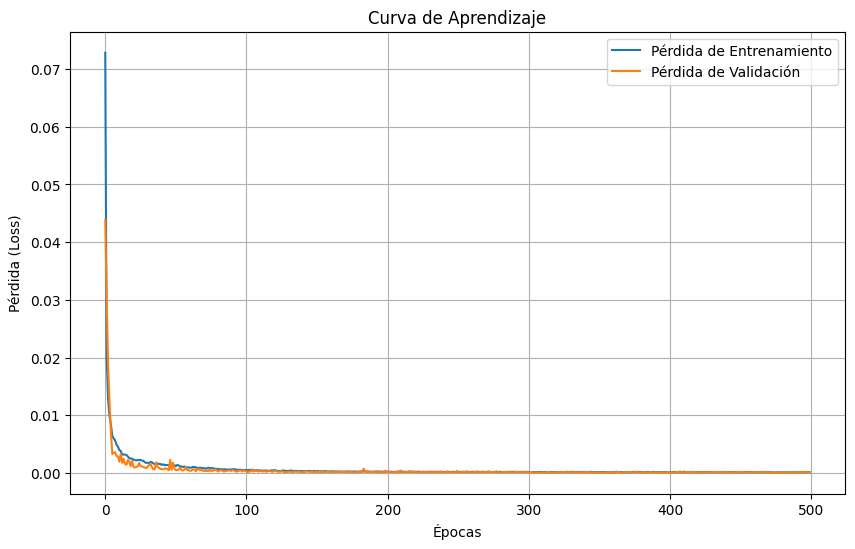

In [60]:
data = pd.read_csv("proyectil_datos.csv")

# Separar características (X) y variables objetivo (y)
X = data[["velocidad", "angulo", "masa", "resistencia"]].values
y = data[["alcance", "altura"]].values

# Escalar los datos
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Crear el modelo
model = Sequential(
    [
        Input(shape=(X_train.shape[1],)),
        Dense(128),
        LeakyReLU(negative_slope=0.1),
        BatchNormalization(),
        Dense(64),
        LeakyReLU(negative_slope=0.1),
        BatchNormalization(),
        Dense(32),
        LeakyReLU(negative_slope=0.1),
        Dense(2, activation="linear"),
    ]
)

model.compile(
    optimizer=Adam(learning_rate=0.001), loss="mean_squared_error", metrics=["mae"]
)

# Entrenar el modelo
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
)

# Evaluar el modelo
loss, mae = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)
relative_error = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = 100 - relative_error

# Desescalar las predicciones para comparación
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)

# Graficar curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Pérdida de Entrenamiento")
plt.plot(history.history["val_loss"], label="Pérdida de Validación")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.title("Curva de Aprendizaje")
plt.legend()
plt.grid()
plt.show()


In [58]:
# Comparar trayectorias reales vs predicciones
def comparar_trayectorias(y_test, y_pred):
    """Genera gráficos de comparación entre trayectorias reales y estimadas."""
    plt.figure(figsize=(10, 6))
    plt.scatter(
        y_test[:, 0],
        y_test[:, 1],
        label="Trayectoria Real",
        alpha=0.6,
        color="blue",
    )
    plt.scatter(
        y_pred[:, 0],
        y_pred[:, 1],
        label="Trayectoria Predicha",
        alpha=0.6,
        color="red",
    )
    plt.xlabel("Alcance (m)")
    plt.ylabel("Altura (m)")
    plt.title("Comparación de Trayectorias: Reales vs Predichas")
    plt.legend()
    plt.grid()
    plt.show()

Error relativo promedio: 7.35%
Precisión del modelo: 92.65%


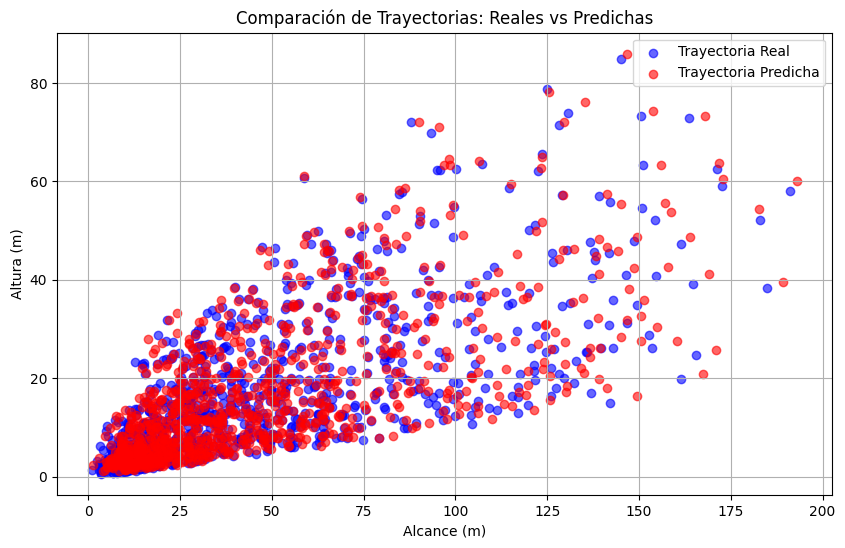

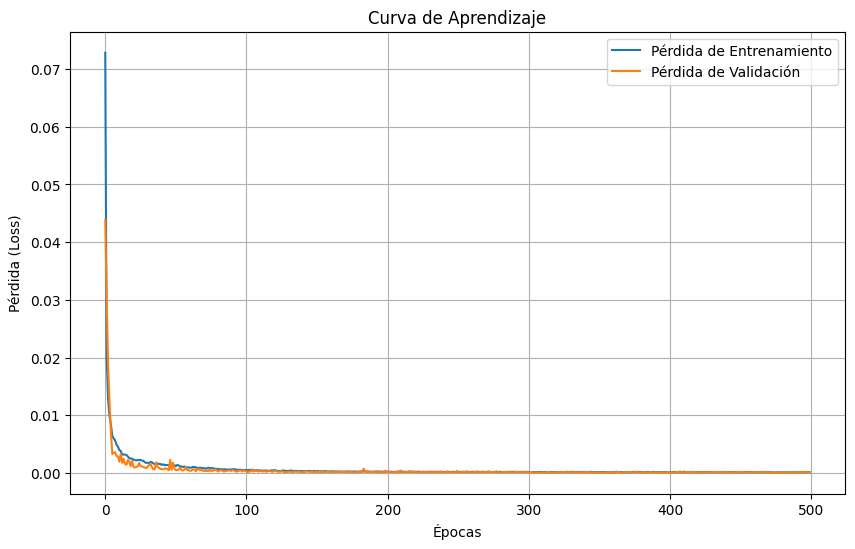

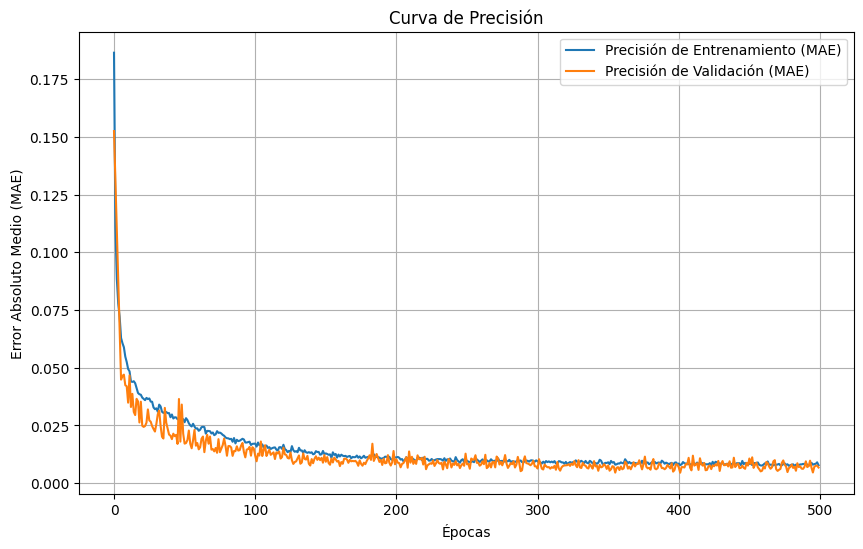

In [61]:
# Calcular error relativo promedio
relative_error = (
    np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
)
accuracy = 100 - relative_error

print(f"Error relativo promedio: {relative_error:.2f}%")
print(f"Precisión del modelo: {accuracy:.2f}%")

comparar_trayectorias(y_test_original, y_pred_original)

# Graficar curva de aprendizaje (pérdida y precisión)
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Pérdida de Entrenamiento")
plt.plot(history.history["val_loss"], label="Pérdida de Validación")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.title("Curva de Aprendizaje")
plt.legend()
plt.grid()
plt.show()

# Error Absoluto Medio
plt.figure(figsize=(10, 6))
plt.plot(history.history["mae"], label="Precisión de Entrenamiento (MAE)")
plt.plot(history.history["val_mae"], label="Precisión de Validación (MAE)")
plt.xlabel("Épocas")
plt.ylabel("Error Absoluto Medio (MAE)")
plt.title("Curva de Precisión")
plt.legend()
plt.grid()
plt.show()
